In [19]:
import matplotlib.pyplot as plt
import vtk
import numpy as np
import os
from spacial_schemes import compute_derivative as derive
import sys  # Import pour arrêter le programme en cas d'erreur

# ------------------------- Fonctions Utilitaires -------------------------

def check_values(variables, names):
    """ Vérifie si des valeurs NaN ou infinies apparaissent dans les variables. """
    for var, name in zip(variables, names):
        if np.any(np.isnan(var)):
            print(f"Erreur : {name} contient des NaN ! Arrêt du programme.")
            sys.exit(1)
        if np.any(np.isinf(var)):
            print(f"Erreur : {name} contient des valeurs infinies ! Arrêt du programme.")
            sys.exit(1)

def apply_boundary_conditions(U_r, U_theta, U_z, R, h, r1, r2, theta1, theta2):
    """
    Réimpose les conditions aux limites Dirichlet à chaque pas de temps.
    Ajoute la gestion de la singularité en r = 0 par symétrie miroir.
    """

    def u_j(r, rj, theta_j):
        return 0.5 * (1 + np.tanh((rj / (2 * theta_j)) * ((rj / r) - (r / rj))))

    # Gestion de la singularité en r = 0 (symétrie miroir)
    U_r[0, :, :] = U_r[1, :, :]
    U_theta[0, :, :] = 0  # Pas de vitesse azimutale en r = 0
    U_z[0, :, :] = U_z[1, :, :]

    # Bord en r_max (Nr-1)
    U_r[-1, :, :] = 0  
    U_theta[-1, :, :] = 0
    U_z[-1, :, :] = 0

    # Bord en z_max (Nz-1)
    U_r[:, :, -1] = 0  
    U_theta[:, :, -1] = 0
    U_z[:, :, -1] = 0 

    # Bord en z_min (Z = 0)
    U_r[:, :, 0] = 0  
    U_theta[:, :, 0] = 0
    U_z[:, :, 0] = (1 - h) * u_j(R[:, :, 0], r1, theta1) + h * u_j(R[:, :, 0], r2, theta2)

    return U_r, U_theta, U_z

# ------------------------- Initialisation -------------------------

def initialize_conditions(R, Theta, Z, gamma, M0, h, r1, r2, theta1, theta2):
    """
    Initialise les conditions aux limites et applique les valeurs initiales aux variables.
    """
    Nr, Ntheta, Nz = R.shape 

    Rho = np.ones((Nr, Ntheta, Nz))  
    P = np.ones((Nr, Ntheta, Nz)) / (gamma * M0**2)  
    
    amplitude_bruit = 1e-6  

    U_r = np.random.uniform(-amplitude_bruit, amplitude_bruit, (Nr, Ntheta, Nz))
    U_theta = np.random.uniform(-amplitude_bruit, amplitude_bruit, (Nr, Ntheta, Nz))
    U_z = np.random.uniform(-amplitude_bruit, amplitude_bruit, (Nr, Ntheta, Nz))

    # Réimpose les conditions aux limites avec la gestion de r = 0
    U_r, U_theta, U_z = apply_boundary_conditions(U_r, U_theta, U_z, R, h, r1, r2, theta1, theta2)

    return Rho, U_r, U_theta, U_z, P

# ------------------------- Mise à jour des équations d'Euler -------------------------

def update_euler(history, dr, dtheta, dz, dt, gamma, M0, R):
    """
    Mise à jour des variables selon les équations d'Euler en coordonnées cylindriques.
    """
    rho, U_r, U_theta, U_z, P, E, T, old_dt = history[-1]

    rho_spatial = (
        derive(R * rho * U_r, dr, axis=0) / R +
        derive(rho * U_theta, dtheta, axis=1) / R +
        derive(rho * U_z, dz, axis=2)
    )
    rho_new = rho - dt * rho_spatial

    U_r_spatial = (
        derive(R * rho * U_r**2, dr, axis=0) / R +
        derive(rho * U_r * U_theta, dtheta, axis=1) / R - rho * U_theta**2 / R +
        derive(rho * U_z * U_r, dz, axis=2) +
        derive(P, dr, axis=0)
    )
    U_r_new = (rho*U_r - dt * U_r_spatial) / rho_new

    U_theta_spatial = (
        derive(R * rho * U_theta * U_r, dr, axis=0) / R +
        derive(rho * U_theta**2 + P, dtheta, axis=1) / R - rho * U_theta * U_r / R +
        derive(rho * U_z * U_theta, dz, axis=2)
    )
    U_theta_new = (rho * U_theta - dt * U_theta_spatial) / rho_new

    U_z_spatial = (
        derive(R * rho * U_z * U_r, dr, axis=0) / R +
        derive(rho * U_z * U_theta, dtheta, axis=1) / R +
        derive(rho * U_z**2 + P, dz, axis=2)
    )
    U_z_new = (rho*U_z - dt * U_z_spatial) / rho_new

    E_spatial = (
        derive(R * (rho * E + P) * U_r, dr, axis=0) / R +
        derive((rho * E + P) * U_theta, dtheta, axis=1) / R +
        derive((rho * E + P) * U_z, dz, axis=2)
    )
    E_new = (rho*E - dt * E_spatial) / rho_new

    p_new = (gamma - 1) * (E_new - 0.5 * rho_new * (U_r_new**2 + U_theta_new**2 + U_z_new**2))
    T_new = p_new * gamma * M0**2 / rho_new

    # Réimposition des conditions limites après mise à jour
    U_r_new, U_theta_new, U_z_new = apply_boundary_conditions(U_r_new, U_theta_new, U_z_new, R, h, r1, r2, theta1, theta2)

    return rho_new, U_r_new, U_theta_new, U_z_new, p_new, E_new, T_new




# ------------------------- Affichages -------------------------

# Fichier paraview
def save_vti(filename, u, v, x, y):
    # Création d'un objet vtkImageData
    grid = vtk.vtkImageData()
    
    # Définir la dimension de la grille en fonction des données
    ny, nx = u.shape
    grid.SetDimensions(nx, ny, 1)
    
    # Calcul des espacements à partir des coordonnées x et y
    dx = x[1] - x[0]  # Supposant un maillage uniforme
    dy = y[1] - y[0]
    grid.SetSpacing(dx, dy, 1)
    
    # Définir l'origine
    grid.SetOrigin(x[0], y[0], 0)
    
    # Conversion des tableaux numpy u et v en vtkArray
    u_flat = u.ravel()
    v_flat = v.ravel()
    w_flat = np.zeros_like(u_flat)  # Composante nulle pour le champ en 2D
    
    # Combiner les composantes u, v et w en un seul champ vectoriel
    velocity_vectors = np.column_stack((u_flat, v_flat, w_flat))
    velocity_vtk = numpy_support.numpy_to_vtk(velocity_vectors, deep=True, array_type=vtk.VTK_FLOAT)
    velocity_vtk.SetName("velocity")
    
    # Ajouter le champ vectoriel au point data de la grille
    grid.GetPointData().SetVectors(velocity_vtk)
    
    # Ecrire dans un fichier VTI
    writer = vtk.vtkXMLImageDataWriter()
    writer.SetFileName(filename)
    writer.SetInputData(grid)
    writer.Write()

def affichage3D(F):
    
    global X, Y, Z

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(X, Y, Z, c=F, cmap='viridis', marker='o', alpha=0.7)

    cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
    cbar.set_label("Valeur de F")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Données en coordonnées cylindriques 3D")



def affichage2D_RZ(F, theta_val, r_max, z_max):
    global R, Theta, Z
    
    theta_val = theta_val % (2*np.pi)

    # Sélection des indices correspondant à la valeur donnée de Theta
    # On cherche l'indice le plus proche de theta_val dans Theta
    indice_theta = np.argmin(np.abs(Theta[0, :, 0] - theta_val), axis=0)
    
    # Extraction des valeurs correspondantes à l'indice theta choisi
    R_slice = R[:, indice_theta, :]
    Z_slice = Z[:, indice_theta, :]
    F_slice = F[:, indice_theta, :]

    # Limiter R entre 0 et r_max et Z entre 0 et z_max
    R_slice = np.clip(R_slice, 0, r_max)
    Z_slice = np.clip(Z_slice, 0, z_max)

    # Affichage de la coupe RZ pour le Theta choisi
    plt.figure(figsize=(8, 6))
    plt.contourf(Z_slice, R_slice, F_slice, levels=50, cmap='viridis')

    # Ajouter une barre de couleur
    plt.colorbar(label="Valeur de F")

    # Labels et titre
    plt.xlabel("Z")
    plt.ylabel("R")
    plt.title(f"Coupe dans le plan RZ (Theta = {theta_val:.2f})")

    # Affichage
    plt.show()


def plot_field_at_z0(R, Theta, F, title="Champ au plan Z = 0", cmap="viridis"):

    # Conversion en coordonnées cartésiennes
    X = R * np.cos(Theta)
    Y = R * np.sin(Theta)

    # Création de la figure
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(X[:, :, 0], Y[:, :, 0], F[:, :, 0], shading='auto', cmap=cmap)
    plt.colorbar(label="Valeur du champ")
    
    # Personnalisation
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)
    plt.axis("equal")  # Pour garder les proportions cylindriques

    # Affichage
    plt.show()







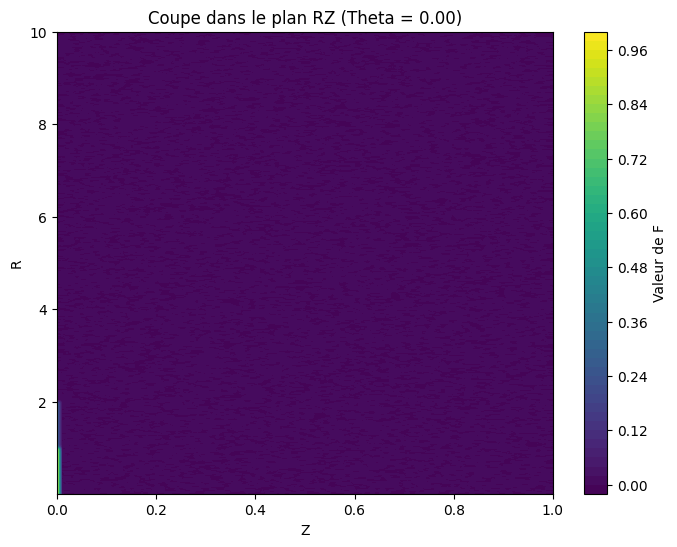

C:\Users\enseignant\AppData\Local\Temp\ipykernel_12868\3233727280.py:227: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X[:, :, 0], Y[:, :, 0], F[:, :, 0], shading='auto', cmap=cmap)


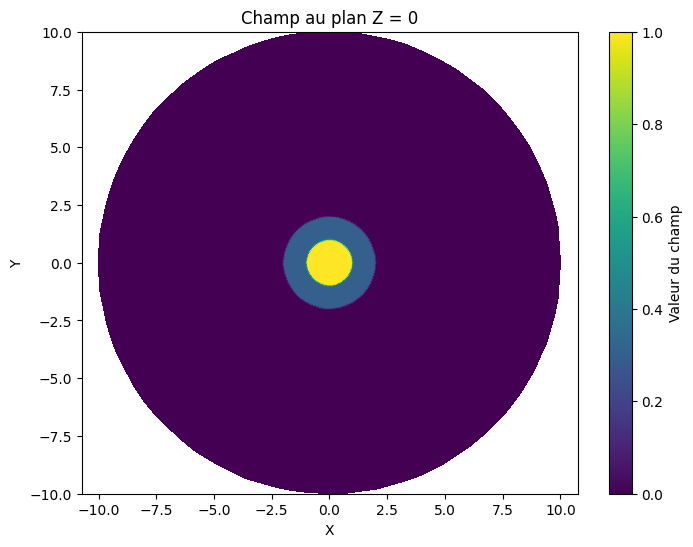

In [20]:

# ---------------------------  Paramètres  --------------------------

# Simulation
T = 5
r_min, r_max, Nr = 0.01, 10, 500  
theta_min, theta_max, Ntheta = 0.0, 2*np.pi, 100
z_min, z_max, Nz = 0.0, 1, 100
CFL = 0.9

# Jet
Up = 5
h = 0.3
Us = h*Up
r1 = 1
r2 = 2
theta1 = 0.03
theta2 = 0.03 

#  Physique
M0 = 0.1
gamma = 1.4


# ------------------------- Initialisations  -------------------------

# Grille
r = np.linspace(r_min, r_max, Nr)
theta = np.linspace(theta_min, theta_max, Ntheta)
z = np.linspace(z_min, z_max, Nz)
R, Theta, Z = np.meshgrid(r, theta, z, indexing='ij')

X = R * np.cos(Theta)
Y = R * np.sin(Theta)

Rho, U_r, U_theta, U_z, P = initialize_conditions(R, Theta, Z, gamma, M0, h, r1, r2, theta1, theta2)

# Énergie totale
E = P / ((gamma - 1) * gamma * M0**2) + 0.5 * Rho * (U_r**2 + U_theta**2 + U_z**2)

affichage2D_RZ(U_z, 0*2*np.pi/100, r_max,z_max)
plot_field_at_z0(R, Theta, U_z, title="Champ au plan Z = 0", cmap="viridis")






In [21]:
# ------------------------- Itérations temporelles  -------------------------

dr = (r_max - r_min)/Nr
dtheta = (theta_max - theta_min)/Ntheta
dz = (z_max - z_min)/Nz
vitesse_max = np.max(np.sqrt(U_r**2 + U_theta**2 + U_z**2))
dt = CFL * min(dr, dtheta, dz) / max(1e-9, vitesse_max)
nb_iter = 0

history = [
    [Rho, U_r, U_theta, U_z, P, E, T, dt],  # État actuel
    [Rho, U_r, U_theta, U_z, P, E, T, dt],  # -1 itération
    [Rho, U_r, U_theta, U_z, P, E, T, dt],  # -2 itérations
    [Rho, U_r, U_theta, U_z, P, E, T, dt],  # -3 itérations
    [Rho, U_r, U_theta, U_z, P, E, T, dt]   # -4 itérations
]

t = 0
while t < T:

    vitesse_max = np.max(np.sqrt(U_r**2 + U_theta**2 + U_z**2))
    dt = CFL * min(dr, dtheta, dz) / max(1e-9, vitesse_max)

    # Calcul du nouvel état
    history_new = update_euler(history, dr, dtheta, dz, dt, gamma, M0, R)

    # Vérification des valeurs après mise à jour
    check_values(history_new, ["Rho", "U_r", "U_theta", "U_z", "P", "E", "T"])

    # Suppression du plus ancien état et ajout du nouveau
    history.pop(0)  
    history.append([arr.copy() for arr in history_new] + [dt])  

    # Affichage formaté des informations de l'itération
    print("\n" + "-" * 50)
    print(f"Itération : {nb_iter}")
    print(f"Temps actuel : t = {t:.6f}")
    print(f"Pas de temps utilisé : dt = {dt:.2e}")
    print("-" * 50)

    t += dt
    nb_iter += 1

# Récupération du dernier état
Rho, U_r, U_theta, U_z, P, E, T, _ = history[-1]

print("\nFin du calcul.")





--------------------------------------------------
Itération : 0
Temps actuel : t = 0.000000
Pas de temps utilisé : dt = 9.00e-03
--------------------------------------------------

--------------------------------------------------
Itération : 1
Temps actuel : t = 0.009000
Pas de temps utilisé : dt = 9.00e-03
--------------------------------------------------

--------------------------------------------------
Itération : 2
Temps actuel : t = 0.018000
Pas de temps utilisé : dt = 9.00e-03
--------------------------------------------------

--------------------------------------------------
Itération : 3
Temps actuel : t = 0.027000
Pas de temps utilisé : dt = 9.00e-03
--------------------------------------------------

--------------------------------------------------
Itération : 4
Temps actuel : t = 0.036000
Pas de temps utilisé : dt = 9.00e-03
--------------------------------------------------

--------------------------------------------------
Itération : 5
Temps actuel : t = 0.045

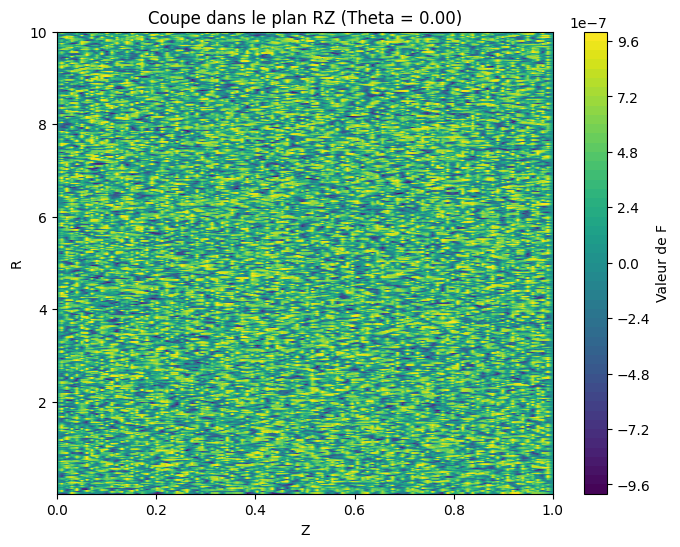

In [25]:
#print(U_r)
affichage2D_RZ(U_r, 0*2*np.pi/100, r_max,z_max)

In [ ]:
affichage3D(U_r)